In [2]:
import os
import sys
import time
import argparse
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import random
from sklearn.exceptions import ConvergenceWarning
from sklearn.cluster import KMeans
from sklearn_extra.cluster import KMedoids
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import spearmanr
from scipy.spatial.distance import cdist
from sklearn import linear_model
import xgboost
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor
import umap
from matplotlib.colors import ListedColormap
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

# Ignore FutureWarnings and ConvergenceWarnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=ConvergenceWarning, module="sklearn.neural_network")
pd.options.mode.chained_assignment = None  # default='warn'


### Functions ported from grid_search

In [3]:
# Function to read in the data
def read_data(dataset_name, base_path, file_type, embeddings_type='both'):
    # Construct the file paths
    if file_type == "csvs":
        labels_file = os.path.join(base_path, 'labels', dataset_name.split('_')[0] + '_labels.csv')
        hie_file = os.path.join(base_path, 'hie_temp', dataset_name.split('_')[0] + '.csv')
        embeddings_file = os.path.join(base_path, 'csvs', dataset_name + '.csv')
        # Read in mean embeddings across all rounds
        embeddings = pd.read_csv(embeddings_file, index_col=0)
    elif file_type == "pts":
        labels_file = os.path.join(base_path, 'labels', dataset_name.split('_')[-1] + '_labels.csv')
        hie_file = os.path.join(base_path, 'hie_temp', dataset_name.split('_')[-1] + '.csv')
        embeddings_file = os.path.join(base_path, 'pts', dataset_name + '.pt')
        # Read in pytorch tensor of embeddings
        embeddings = torch.load(embeddings_file)
        # Convert embeddings to a dataframe
        if embeddings_type == 'average':
            embeddings = {key: value['average'].numpy() for key, value in embeddings.items()}
        elif embeddings_type == 'mutated':
            embeddings = {key: value['mutated'].numpy() for key, value in embeddings.items()}
        elif embeddings_type == 'both':
            embeddings = {key: torch.cat((value['average'], value['mutated'])).numpy() for key, value in embeddings.items()}
        else:
            print("Invalid embeddings_type. Please choose 'average', 'mutated', or 'both'")
            return None, None

        # Convert embeddings dictionary to a dataframe
        embeddings = pd.DataFrame.from_dict(embeddings, orient='index')
    else:
        print("Invalid file type. Please choose either 'csvs' or 'pts'")
        return None, None

    # Read in labels
    labels = pd.read_csv(labels_file)

    # Read in hierarchy
    hie_data = pd.read_csv(hie_file)

    # Filter out rows where fitness is NaN
    labels = labels[labels['fitness'].notna()]

    # Filter out rows in embeddings where row names are not in labels variant column
    embeddings = embeddings[embeddings.index.isin(labels['variant'])]

    # Align labels by variant
    labels = labels.sort_values(by=['variant'])

    # Align embeddings by row name
    embeddings = embeddings.sort_index()

    # Confirm that labels and embeddings are aligned, reset index
    labels = labels.reset_index(drop=True)

    # Get the variants in labels and embeddings, convert to list
    label_variants = labels['variant'].tolist()
    embedding_variants = embeddings.index.tolist()

    # Check if embedding row names and label variants are identical
    if label_variants == embedding_variants:
        print('Embeddings and labels are aligned')

    # return embeddings and labels
    return embeddings, labels, hie_data

# Function to scale the embeddings in the dataframe
def scale_embeddings(embeddings_df):
    
    scaler = StandardScaler()
    scaled_embeddings = scaler.fit_transform(embeddings_df)

    scaled_embeddings_df = pd.DataFrame(scaled_embeddings)

    return scaled_embeddings_df

# Perform PCA on the embeddings
def pca_embeddings(embeddings_df, labels_df, dataset_name, n_components=8):
    # Perform PCA on the embeddings
    pca = PCA(n_components=50)
    embeddings_pca = pca.fit_transform(embeddings_df)
    # Get the embeddings for the top n_components
    embeddings_pca = embeddings_pca[:, :n_components]
    # Convert embeddings to a dataframe
    embeddings_pca_df = pd.DataFrame(embeddings_pca, columns=[f'PCA {i}' for i in range(1, n_components + 1)])

    return embeddings_pca_df

# Function for selecting mutants in the first round
def first_round(labels, embeddings, hie_data, num_mutants_per_round, first_round_strategy='random', random_seed=None):

    # Filter out 'WT' variant from labels
    variants_without_WT = labels.variant[labels.variant != 'WT']

    # Perform random first round search strategy
    if first_round_strategy == 'random':
        # Set random seed
        if random_seed is not None:
            np.random.seed(random_seed)  # Use NumPy's random seed for consistent randomization
        random_mutants = np.random.choice(variants_without_WT, size=num_mutants_per_round, replace=False)
        iteration_one_ids = random_mutants

    elif first_round_strategy == 'diverse_medoids':
        # Set random seed
        if random_seed is not None:
            np.random.seed(random_seed)  # Use NumPy's random seed for consistent randomization
        num_clusters = num_mutants_per_round
        
        # Perform PCA with 100 dimensions
        pca = PCA(n_components=100)
        pca_embeddings = pca.fit_transform(embeddings)
        pca_embeddings_reduced = pca_embeddings[:, :2]
        
        # Perform K-medoids clustering on PCA embeddings
        clusters = KMedoids(n_clusters=num_clusters, metric='euclidean', random_state=random_seed).fit(pca_embeddings_reduced)
        cluster_medoids = clusters.medoid_indices_
        cluster_labels = clusters.labels_

        # Select one medoid per cluster
        selected_mutants = []
        for cluster_idx in range(num_clusters):
            cluster_variants = variants_without_WT[cluster_labels == cluster_idx]
            if len(cluster_variants) > 0:
                # Select the medoid variant from the cluster
                selected_medoid = cluster_variants[cluster_medoids[cluster_idx]]
                selected_mutants.append(selected_medoid)

        iteration_one_ids = selected_mutants

    elif first_round_strategy == 'representative_hie':
        # iteration_one_ids should be the 0th column of the hie_data DataFrame
        iteration_one_ids = hie_data.iloc[:, 0].tolist()
    else:
        print("Invalid first round search strategy.")
        return None, None

    # Create DataFrame for the first round
    iteration_one = pd.DataFrame({'variant': iteration_one_ids, 'iteration': 1})
    WT = pd.DataFrame({'variant': 'WT', 'iteration': 0}, index=[0])
    iteration_one = iteration_one.append(WT)

    # Merge with labels DataFrame and fill null values with 1001
    labels_one = pd.merge(labels, iteration_one, on='variant', how='left')
    labels_one.iteration[labels_one.iteration.isnull()] = 1001

    return labels_one, iteration_one

### New functions

In [4]:
def diverse_medoids_clustering(data, num_clusters):
    kmedoids = KMedoids(n_clusters=num_clusters, metric='euclidean', random_state=42)
    clusters = kmedoids.fit(data)
    medoids = data[clusters.medoid_indices_]
    return clusters, medoids

def plot_dataset_visualizations(labels, embeddings, num_mutants_per_round):
    # Perform PCA with 100 dimensions
    pca = PCA(n_components=100)
    pca_embeddings = pca.fit_transform(embeddings)
    
    # Perform UMAP on PCA output
    reducer_umap = umap.UMAP(n_components=2)
    umap_embeddings = reducer_umap.fit_transform(pca_embeddings)
    
    # Perform t-SNE on PCA output
    reducer_tsne = TSNE(n_components=2, perplexity=30, n_iter=300)
    tsne_embeddings = reducer_tsne.fit_transform(pca_embeddings)

    # Perform K-means clustering on PCA embeddings
    pca_embeddings_reduced = pca_embeddings[:, :2]
    clusters_pca, medoids_pca = diverse_medoids_clustering(pca_embeddings_reduced, num_clusters=num_mutants_per_round)
    
    # Perform K-medoids clustering on UMAP embeddings
    clusters_umap, medoids_umap = diverse_medoids_clustering(umap_embeddings, num_clusters=num_mutants_per_round)
    
    # Perform K-medoids clustering on t-SNE embeddings
    clusters_tsne, medoids_tsne = diverse_medoids_clustering(tsne_embeddings, num_clusters=num_mutants_per_round)
    
    # Create a single plot with 9 subplots (3 rows, 3 columns)
    fig, axes = plt.subplots(3, 3, figsize=(18, 18))
    
    # Plot PCA embeddings with fitness scaling
    sc = axes[0, 0].scatter(pca_embeddings[:, 0], pca_embeddings[:, 1], c=labels["fitness_scaled"], cmap='viridis')
    cbar = plt.colorbar(sc, ax=axes[0, 0])
    cbar.set_label('Fitness Z-score')
    axes[0, 0].set_xlabel('PCA 1')
    axes[0, 0].set_ylabel('PCA 2')
    axes[0, 0].set_title('PCA Embeddings')
    
    # Plot UMAP embeddings with fitness scaling
    scatter = axes[0, 1].scatter(umap_embeddings[:, 0], umap_embeddings[:, 1], c=labels["fitness_scaled"], cmap='viridis')
    cbar = plt.colorbar(scatter, ax=axes[0, 1])
    cbar.set_label('Fitness Z-score')
    axes[0, 1].set_xlabel('UMAP 1')
    axes[0, 1].set_ylabel('UMAP 2')
    axes[0, 1].set_title('UMAP Embeddings')
    
    # Plot t-SNE embeddings with fitness scaling
    scatter = axes[0, 2].scatter(tsne_embeddings[:, 0], tsne_embeddings[:, 1], c=labels["fitness_scaled"], cmap='viridis')
    cbar = plt.colorbar(scatter, ax=axes[0, 2])
    cbar.set_label('Fitness Z-score')
    axes[0, 2].set_xlabel('t-SNE 1')
    axes[0, 2].set_ylabel('t-SNE 2')
    axes[0, 2].set_title('t-SNE Embeddings')

    # Plot PCA embeddings with fitness_binary highlighting
    binary_colormap = ListedColormap(['gray', 'red'])
    sc = axes[1, 0].scatter(pca_embeddings[labels["fitness_binary"] == 0, 0],
                            pca_embeddings[labels["fitness_binary"] == 0, 1],
                            c=labels["fitness_binary"][labels["fitness_binary"] == 0],
                            cmap=binary_colormap, vmin=0, vmax=1)
    sc = axes[1, 0].scatter(pca_embeddings[labels["fitness_binary"] == 1, 0],
                            pca_embeddings[labels["fitness_binary"] == 1, 1],
                            c=labels["fitness_binary"][labels["fitness_binary"] == 1],
                            cmap=binary_colormap, vmin=0, vmax=1)
    axes[1, 0].set_xlabel('PCA 1')
    axes[1, 0].set_ylabel('PCA 2')
    axes[1, 0].set_title('PCA Embeddings (Fitness Binary)')

    # Plot UMAP embeddings with fitness_binary highlighting
    sc = axes[1, 1].scatter(umap_embeddings[labels["fitness_binary"] == 0, 0],
                            umap_embeddings[labels["fitness_binary"] == 0, 1],
                            c=labels["fitness_binary"][labels["fitness_binary"] == 0],
                            cmap=binary_colormap, vmin=0, vmax=1)
    sc = axes[1, 1].scatter(umap_embeddings[labels["fitness_binary"] == 1, 0],
                            umap_embeddings[labels["fitness_binary"] == 1, 1],
                            c=labels["fitness_binary"][labels["fitness_binary"] == 1],
                            cmap=binary_colormap, vmin=0, vmax=1)    
    axes[1, 1].set_xlabel('UMAP 1')
    axes[1, 1].set_ylabel('UMAP 2')
    axes[1, 1].set_title('UMAP Embeddings (Fitness Binary)')
    
    # Plot t-SNE embeddings with fitness_binary highlighting
    sc = axes[1, 2].scatter(tsne_embeddings[labels["fitness_binary"] == 0, 0],
                            tsne_embeddings[labels["fitness_binary"] == 0, 1],
                            c=labels["fitness_binary"][labels["fitness_binary"] == 0],
                            cmap=binary_colormap, vmin=0, vmax=1)
    sc = axes[1, 2].scatter(tsne_embeddings[labels["fitness_binary"] == 1, 0],
                            tsne_embeddings[labels["fitness_binary"] == 1, 1],
                            c=labels["fitness_binary"][labels["fitness_binary"] == 1],
                            cmap=binary_colormap, vmin=0, vmax=1)    
    axes[1, 2].set_xlabel('t-SNE 1')
    axes[1, 2].set_ylabel('t-SNE 2')
    axes[1, 2].set_title('t-SNE Embeddings (Fitness Binary)')

    # Plot PCA K-medoids clustering
    scatter = axes[2, 0].scatter(pca_embeddings[:, 0], pca_embeddings[:, 1], c=clusters_pca.labels_, cmap='plasma')
    medoids = medoids_pca
    axes[2, 0].scatter(medoids[:, 0], medoids[:, 1], c='red', marker='X', s=100, label='Cluster Medoids')
    axes[2, 0].set_xlabel('PCA 1')
    axes[2, 0].set_ylabel('PCA 2')
    axes[2, 0].set_title('PCA K-medoids Clustering')
    axes[2, 0].legend()
    
    # Plot UMAP K-medoids clustering
    scatter = axes[2, 1].scatter(umap_embeddings[:, 0], umap_embeddings[:, 1], c=clusters_umap.labels_, cmap='plasma')
    medoids = medoids_umap
    axes[2, 1].scatter(medoids[:, 0], medoids[:, 1], c='red', marker='X', s=100, label='Cluster Medoids')
    axes[2, 1].set_xlabel('UMAP 1')
    axes[2, 1].set_ylabel('UMAP 2')
    axes[2, 1].set_title('UMAP K-medoids Clustering')
    axes[2, 1].legend()
    
    # Plot t-SNE K-medoids clustering
    scatter = axes[2, 2].scatter(tsne_embeddings[:, 0], tsne_embeddings[:, 1], c=clusters_tsne.labels_, cmap='plasma')
    medoids = medoids_tsne
    axes[2, 2].scatter(medoids[:, 0], medoids[:, 1], c='red', marker='X', s=100, label='Cluster Medoids')
    axes[2, 2].set_xlabel('t-SNE 1')
    axes[2, 2].set_ylabel('t-SNE 2')
    axes[2, 2].set_title('t-SNE K-medoids Clustering')
    axes[2, 2].legend()
        
    plt.tight_layout()
    plt.show()

def full_regression(labels, embeddings, measured_var, regression_types=None, test_size=0.2, random_state=1):
    if regression_types is None:
        regression_types = ['ridge', 'lasso', 'elasticnet', 'linear', 'neuralnet', 'randomforest', 'gradientboosting']
    
    results = []

    # reset the indices of embeddings_pd and labels_pd
    embeddings = embeddings.reset_index(drop=True)
    labels = labels.reset_index(drop=True)

    X = embeddings
    y = labels[measured_var]

    # Split the data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
    
    for regression_type in regression_types:
        # fit
        if regression_type == 'ridge':
            model = linear_model.RidgeCV()
        elif regression_type == 'lasso':
            model = linear_model.LassoCV()
        elif regression_type == 'elasticnet':
            model = linear_model.ElasticNetCV()
        elif regression_type == 'linear':
            model = linear_model.LinearRegression()
        elif regression_type == 'neuralnet':
            model = MLPRegressor(hidden_layer_sizes=(5), max_iter=1000, activation='relu', solver='adam', alpha=0.001,
                                 batch_size='auto', learning_rate='constant', learning_rate_init=0.001, power_t=0.5,
                                 momentum=0.9, nesterovs_momentum=True, shuffle=True, random_state=1, tol=0.0001,
                                 verbose=False, warm_start=False, early_stopping=False, validation_fraction=0.1,
                                 beta_1=0.9, beta_2=0.999, epsilon=1e-08)
        elif regression_type == 'randomforest':
            model = RandomForestRegressor(n_estimators=100, criterion='friedman_mse', max_depth=None,
                                          min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0,
                                          max_features='auto', max_leaf_nodes=None, min_impurity_decrease=0.0,
                                          bootstrap=True, oob_score=False, n_jobs=None, random_state=1, verbose=0,
                                          warm_start=False, ccp_alpha=0.0, max_samples=None)
        elif regression_type == 'gradientboosting':
            model = xgboost.XGBRegressor(objective='reg:squarederror', colsample_bytree=0.3, learning_rate=0.1,
                                          max_depth=5, alpha=10, n_estimators=10)

        print(regression_type)
        model.fit(X_train, y_train)

        # make predictions on the test set
        y_pred = model.predict(X_test)

        # calculate metrics on the test set
        r_squared = r2_score(y_test, y_pred)
        spearman_corr, _ = spearmanr(y_test, y_pred)

        results.append({'Regression Type': regression_type,
                        'R^2': r_squared,
                        'Spearman Correlation': spearman_corr})

    results_df = pd.DataFrame(results)
    return results_df

# def random_forest_optimization_random(embeddings, labels, measured_var, test_size=0.2, n_iter=100, random_state=42):
#     # Reset the indices of embeddings and labels
#     embeddings = embeddings.reset_index(drop=True)
#     labels = labels.reset_index(drop=True)

#     X = embeddings
#     y = labels[measured_var]

#     # Split the data into train and test sets
#     X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

#     # Define the random grid for hyperparameter tuning
#     random_grid = {'n_estimators': [200, 400, 600, 800, 1000],
#                    'max_features': ['auto', 'sqrt'],
#                    'max_depth': [10, 20, 30, 40, 50, None],
#                    'min_samples_split': [2, 5, 10],
#                    'min_samples_leaf': [1, 2, 4],
#                    'bootstrap': [True, False]}
    
#     # Create the base Random Forest model
#     rf = RandomForestRegressor()

#     # Perform RandomizedSearchCV for hyperparameter tuning
#     rf_random = RandomizedSearchCV(estimator=rf, param_distributions=random_grid, n_iter=n_iter, cv=3,
#                                    verbose=2, random_state=random_state, n_jobs=-1)
    
#     # Fit the random search model
#     rf_random.fit(X_train, y_train)

#     # Use the best estimator from random search
#     best_estimator = rf_random.best_estimator_

#     # Make predictions on the test set
#     y_pred = best_estimator.predict(X_test)

#     # Calculate metrics on the test set
#     r_squared = r2_score(y_test, y_pred)
#     spearman_corr, _ = spearmanr(y_test, y_pred)

#     results = {'R^2': r_squared, 'Spearman Correlation': spearman_corr}
#     return best_estimator, results

# measured_var = 'fitness_scaled'
# random_grid_best_estimator, random_grid_search_results = random_forest_optimization_random(embeddings, labels, measured_var)


In [5]:
# import brenan data
dataset_name = 'markin_esm2_t33_650M_UR50D'
base_path = '/Users/matteodibernardo/Documents/GitHub/directed_evolution/esm-extract/results_means/'
file_type = 'csvs'

embeddings, labels, hie_data = read_data(dataset_name, base_path, file_type)

Embeddings and labels are aligned


In [6]:
hie_data

,variant,DMS_kcat,DMS_km,DMS_kcat_km,esm1b_t33_650M_UR50S,esm1v_t33_650M_UR90S_1,esm1v_t33_650M_UR90S_2,esm1v_t33_650M_UR90S_3,esm1v_t33_650M_UR90S_4,esm1v_t33_650M_UR90S_5,ESM_summed,ESM_vote,esm1b_t33_650M_UR50S_vote,esm1v_t33_650M_UR90S_2_vote,esm1v_t33_650M_UR90S_1_vote,esm1v_t33_650M_UR90S_3_vote,esm1v_t33_650M_UR90S_4_vote,esm1v_t33_650M_UR90S_5_vote
0,V51A,210.0,75.0,2400000.0,0.579584,-3.162576,-2.493095,-2.307363,-0.630714,-2.646420,-10.660584,1,1,0,0,0,0,0
1,D85V,140.0,96.0,1500000.0,-6.238914,-3.735200,0.479128,-5.058442,-6.397129,-6.610976,-27.561532,1,0,1,0,0,0,0
2,S224G,77.0,66.0,1300000.0,-1.314803,2.102496,-1.857820,-1.779626,-1.938925,-2.141324,-6.930002,1,0,0,1,0,0,0
3,D272G,130.0,59.0,1900000.0,1.066262,-6.078020,-7.007128,-3.443149,-5.449760,-3.539699,-24.451494,1,1,0,0,0,0,0
4,T350G,180.0,73.0,2400000.0,-0.186449,-2.684613,-1.675323,1.025805,-0.210775,-0.810117,-4.541474,1,0,0,0,1,0,0
5,V354G,60.0,52.0,1000000.0,0.238509,-1.863820,-2.059388,-2.995029,-0.539868,-1.824836,-9.044432,1,1,0,0,0,0,0
6,A459G,89.0,83.0,1300000.0,-3.110043,-1.262485,-0.563271,-2.746548,-2.861721,0.654665,-9.889400,1,0,0,0,0,0,1
7,K463G,78.0,78.0,1100000.0,-4.021323,-4.491968,-6.479095,2.237633,-4.761840,-2.713011,-20.229604,1,0,0,0,1,0,0
8,S468G,90.0,48.0,1300000.0,-2.916479,-2.290242,-0.955343,0.672154,-3.031345,-3.513203,-12.034459,1,0,0,0,1,0,0
9,Y495V,67.0,90.0,730000.0,0.567274,-3.684648,-5.278632,-0.720608,-0.952688,-3.351853,-13.421156,1,1,0,0,0,0,0


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


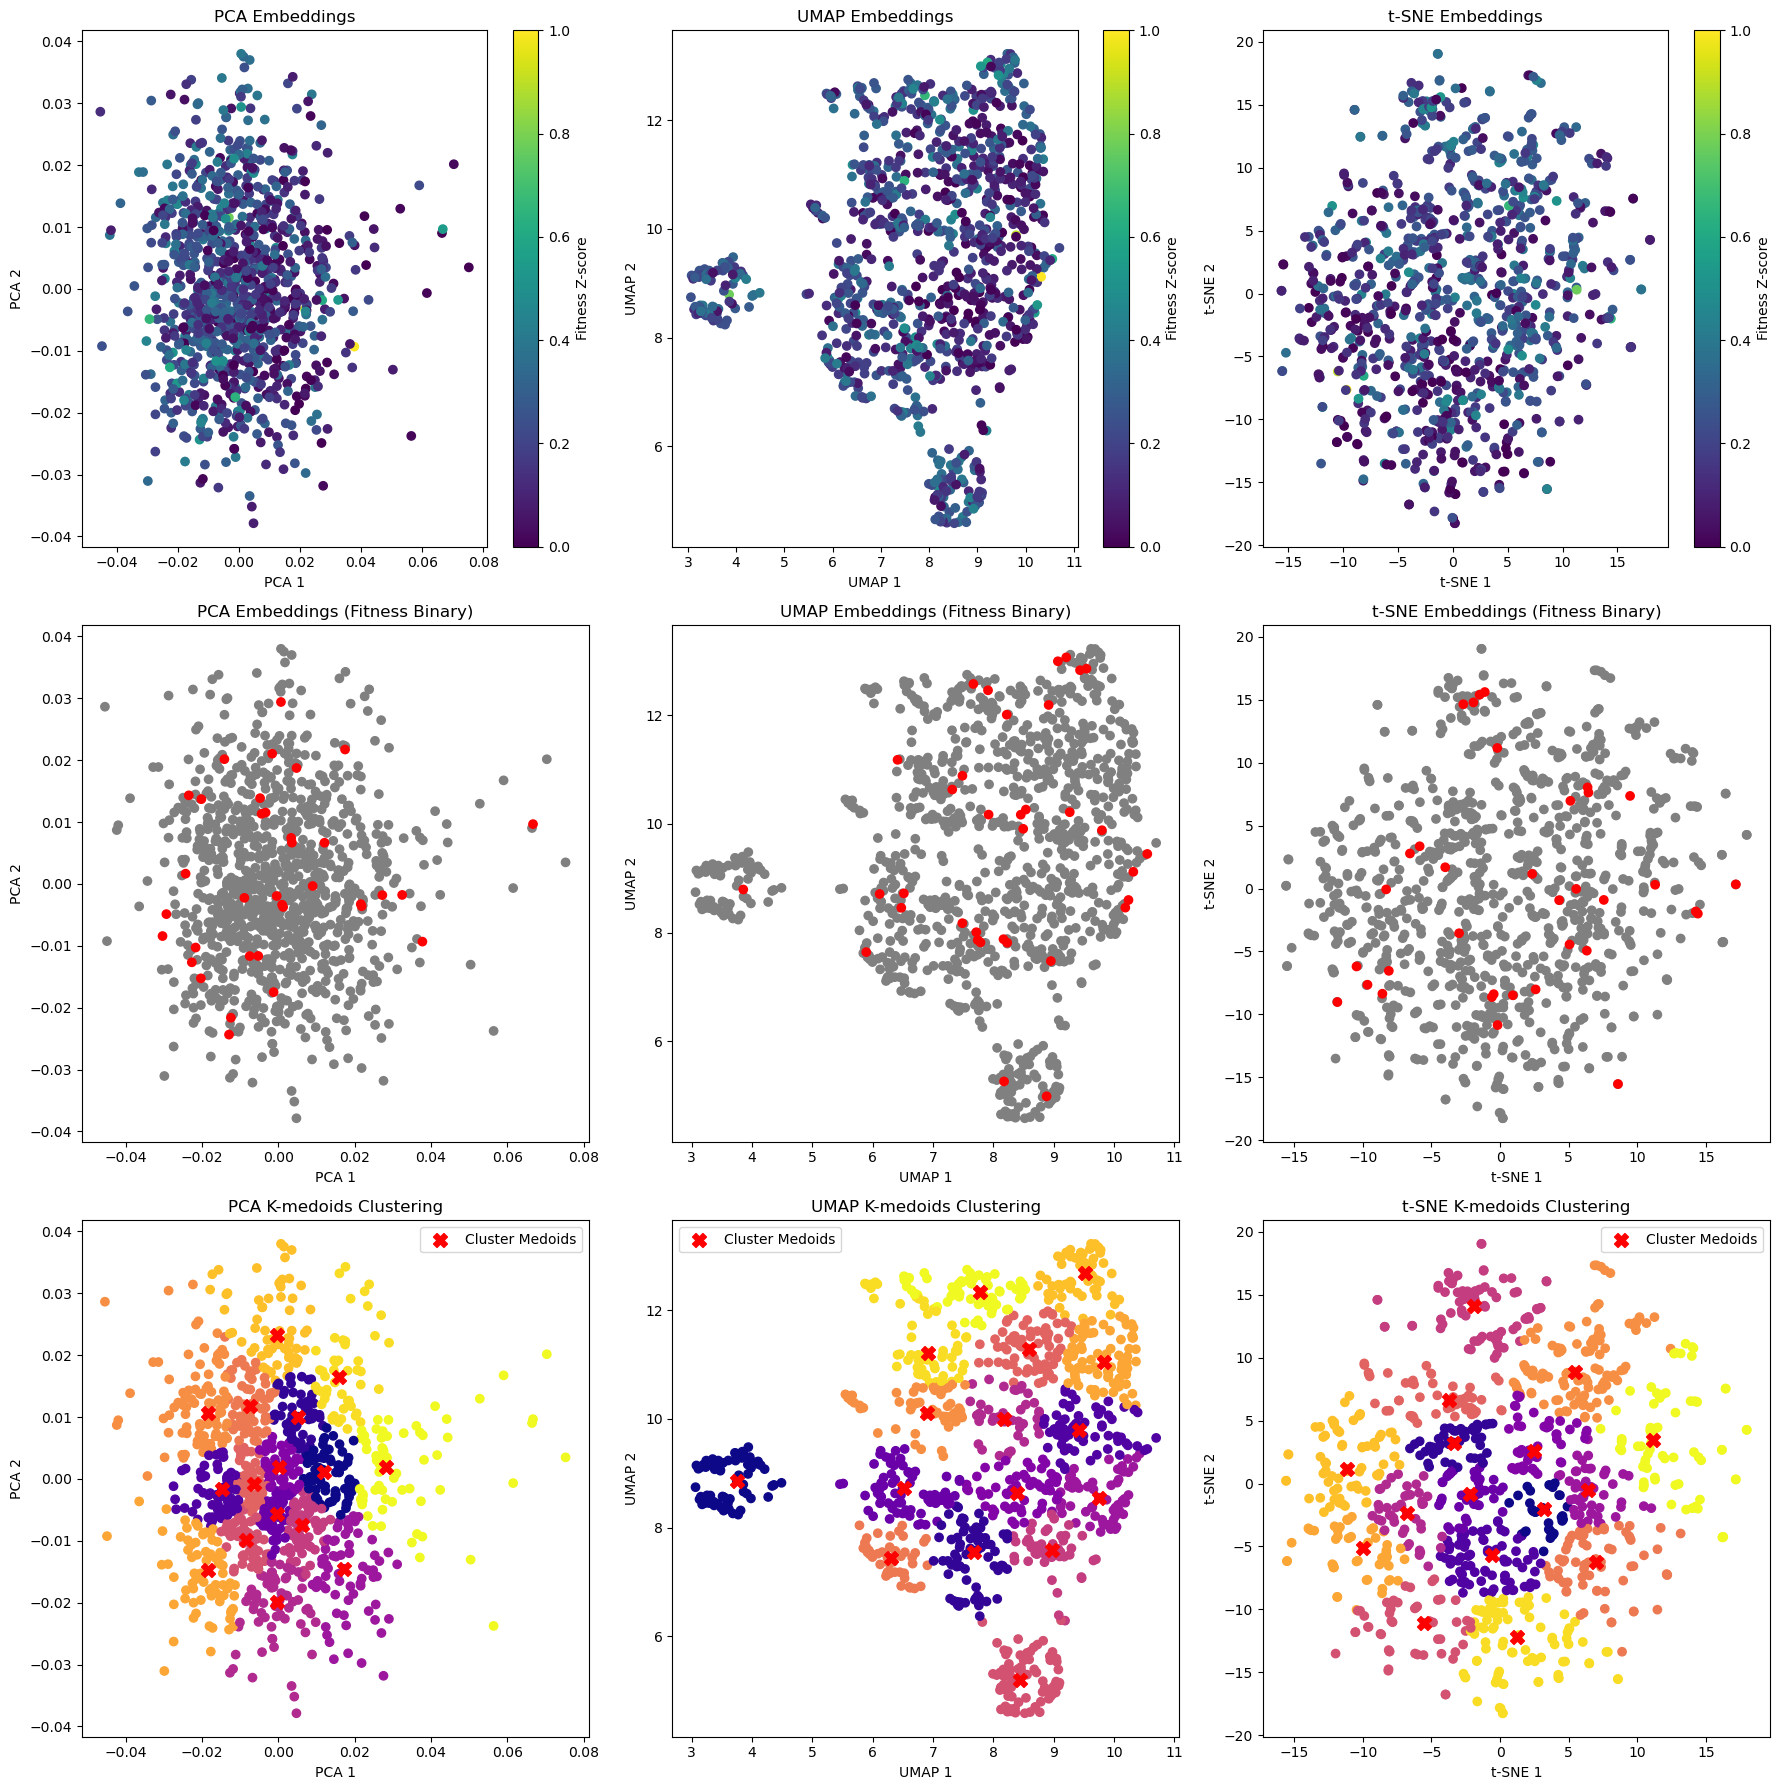

In [7]:
# Call the function
dataset_name = 'brenan_esm1b_t33_650M_UR50S'
num_mutants_per_round = 16
plot_dataset_visualizations(labels, embeddings, num_mutants_per_round)

In [ ]:
measured_var = 'fitness_scaled'
results_df = full_regression(labels, embeddings, measured_var)
# Print the results
print(results_df)

In [9]:
# get the first round of mutants
num_mutants_per_round = 16
labels_one, iteration_one = first_round(labels, embeddings, hie_data, num_mutants_per_round, first_round_strategy='random', random_seed=1)

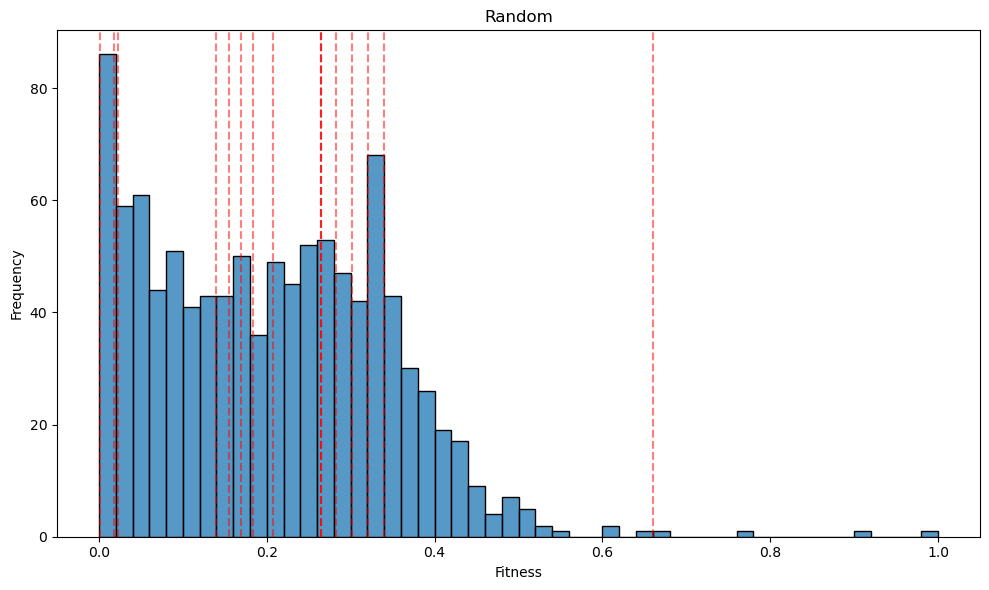

In [10]:
plt.figure(figsize=(10, 6))
sns.histplot(data=labels_one, x='fitness_scaled', bins=50)
for variant in iteration_one['variant']:
    if variant in labels_one['variant'].values:
        fitness_value = labels_one.loc[labels_one['variant'] == variant, 'fitness_scaled'].values[0]
        plt.axvline(x=fitness_value, color='red', linestyle='dashed', label=f'Iteration 1: {variant}', alpha=0.5)
plt.xlabel('Fitness')
plt.ylabel('Frequency')
plt.title('Random')
plt.tight_layout()
plt.show()


In [11]:
# first round percent high fitness
print((labels_one[labels_one['iteration'] == 1]['fitness_binary'].sum() / len(labels_one[labels_one['iteration'] == 1])) * 100)

6.25


In [12]:
# get the first round of mutants
num_mutants_per_round = 16
labels_one, iteration_one = first_round(labels, embeddings, hie_data, num_mutants_per_round, first_round_strategy='diverse_medoids')

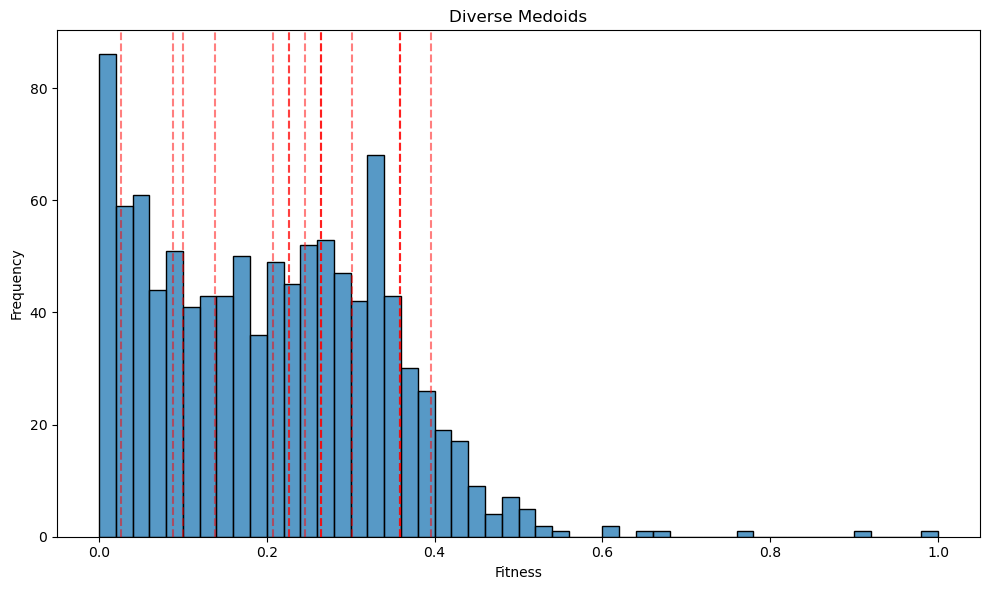

In [13]:
plt.figure(figsize=(10, 6))
sns.histplot(data=labels_one, x='fitness_scaled', bins=50)
for variant in iteration_one['variant']:
    if variant in labels_one['variant'].values:
        fitness_value = labels_one.loc[labels_one['variant'] == variant, 'fitness_scaled'].values[0]
        plt.axvline(x=fitness_value, color='red', linestyle='dashed', label=f'Iteration 1: {variant}', alpha=0.5)
plt.xlabel('Fitness')
plt.ylabel('Frequency')
plt.title('Diverse Medoids')
plt.tight_layout()
plt.show()


In [14]:
# first round percent high fitness
print((labels_one[labels_one['iteration'] == 1]['fitness_binary'].sum() / len(labels_one[labels_one['iteration'] == 1])) * 100)

0.0


In [15]:
# get the first round of mutants
num_mutants_per_round = 16
labels_one, iteration_one = first_round(labels, embeddings, hie_data, num_mutants_per_round, first_round_strategy='representative_hie')

In [16]:
iteration_one

,variant,iteration
0,V51A,1
1,D85V,1
2,S224G,1
3,D272G,1
4,T350G,1
5,V354G,1
6,A459G,1
7,K463G,1
8,S468G,1
9,Y495V,1


In [17]:
hie_data

,variant,DMS_kcat,DMS_km,DMS_kcat_km,esm1b_t33_650M_UR50S,esm1v_t33_650M_UR90S_1,esm1v_t33_650M_UR90S_2,esm1v_t33_650M_UR90S_3,esm1v_t33_650M_UR90S_4,esm1v_t33_650M_UR90S_5,ESM_summed,ESM_vote,esm1b_t33_650M_UR50S_vote,esm1v_t33_650M_UR90S_2_vote,esm1v_t33_650M_UR90S_1_vote,esm1v_t33_650M_UR90S_3_vote,esm1v_t33_650M_UR90S_4_vote,esm1v_t33_650M_UR90S_5_vote
0,V51A,210.0,75.0,2400000.0,0.579584,-3.162576,-2.493095,-2.307363,-0.630714,-2.646420,-10.660584,1,1,0,0,0,0,0
1,D85V,140.0,96.0,1500000.0,-6.238914,-3.735200,0.479128,-5.058442,-6.397129,-6.610976,-27.561532,1,0,1,0,0,0,0
2,S224G,77.0,66.0,1300000.0,-1.314803,2.102496,-1.857820,-1.779626,-1.938925,-2.141324,-6.930002,1,0,0,1,0,0,0
3,D272G,130.0,59.0,1900000.0,1.066262,-6.078020,-7.007128,-3.443149,-5.449760,-3.539699,-24.451494,1,1,0,0,0,0,0
4,T350G,180.0,73.0,2400000.0,-0.186449,-2.684613,-1.675323,1.025805,-0.210775,-0.810117,-4.541474,1,0,0,0,1,0,0
5,V354G,60.0,52.0,1000000.0,0.238509,-1.863820,-2.059388,-2.995029,-0.539868,-1.824836,-9.044432,1,1,0,0,0,0,0
6,A459G,89.0,83.0,1300000.0,-3.110043,-1.262485,-0.563271,-2.746548,-2.861721,0.654665,-9.889400,1,0,0,0,0,0,1
7,K463G,78.0,78.0,1100000.0,-4.021323,-4.491968,-6.479095,2.237633,-4.761840,-2.713011,-20.229604,1,0,0,0,1,0,0
8,S468G,90.0,48.0,1300000.0,-2.916479,-2.290242,-0.955343,0.672154,-3.031345,-3.513203,-12.034459,1,0,0,0,1,0,0
9,Y495V,67.0,90.0,730000.0,0.567274,-3.684648,-5.278632,-0.720608,-0.952688,-3.351853,-13.421156,1,1,0,0,0,0,0


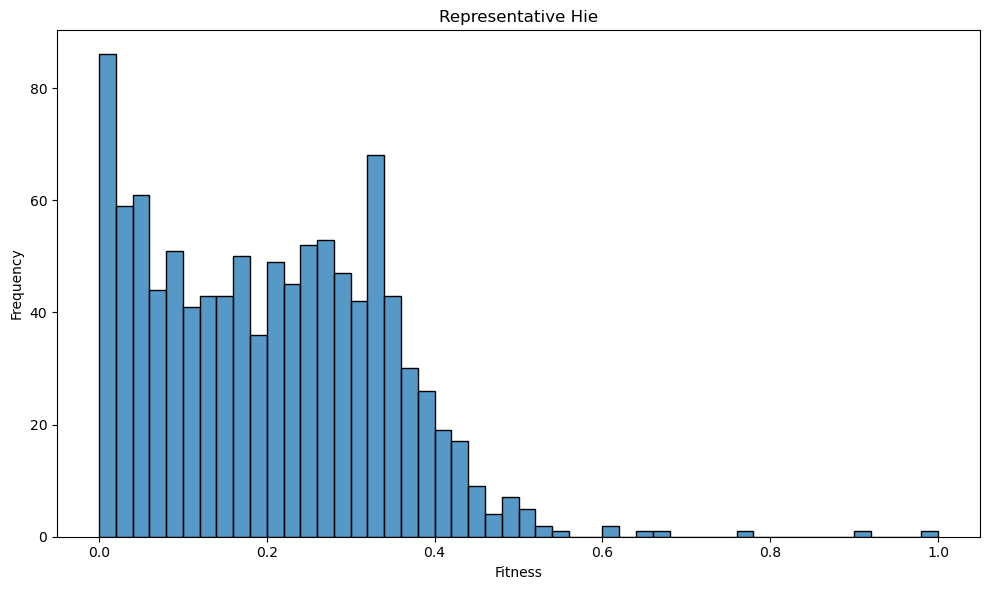

In [18]:
plt.figure(figsize=(10, 6))
sns.histplot(data=labels_one, x='fitness_scaled', bins=50)
for variant in iteration_one['variant']:
    if variant in labels_one['variant'].values:
        fitness_value = labels_one.loc[labels_one['variant'] == variant, 'fitness_scaled'].values[0]
        plt.axvline(x=fitness_value, color='red', linestyle='dashed', label=f'Iteration 1: {variant}', alpha=0.5)
plt.xlabel('Fitness')
plt.ylabel('Frequency')
plt.title('Representative Hie')
plt.tight_layout()
plt.show()


In [126]:
# first round percent high fitness
print((labels_one[labels_one['iteration'] == 1]['fitness_binary'].sum() / len(labels_one[labels_one['iteration'] == 1])) * 100)

6.666666666666667
